# Random forest for pianist classification

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, ParameterSampler
from joblib import Parallel, delayed

from src import utils
from src.features.features_utils import PhaseCorrection, BeatUpbeatRatio, IOIComplexity, TempoSlope, ProportionalAsynchrony, RollingIOISummaryStats
from src.detect.detect_utils import OnsetMaker
from src.visualise.random_forest_plots import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
# Number of iterations to use in random sampling
N_ITER = 250

In [3]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Define predictor and prediction variables, get mappings

In [4]:
# Define target/prediction variables
EXOG_INS = 'piano'
PREDICTION = 'pianist'

In [5]:
# These are the underlying categories each predictor belongs to
PREDICTORS_CATEGORIES = {
    'Swing': ['bur_log_mean', 'bur_log_std'],
    'Complexity': ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
    'Feel': ['piano_bass_prop_async_nanmean', 'piano_drums_prop_async_nanmean', 'piano_bass_prop_async_nanstd', 'piano_drums_prop_async_nanstd'],
    'Interaction': ['self_coupling', 'coupling_drums', 'coupling_bass', 'coupling_piano_drums', 'coupling_piano_bass'],
    'Tempo': ['rolling_std_median', 'tempo', 'tempo_slope', 'tempo_drift']
}
PREDICTORS = [it for sl in list(PREDICTORS_CATEGORIES.values()) for it in sl]

In [6]:
# This creates a dictionary for mapping a predictor onto its category
CATEGORY_MAPPING = {}
for pred in PREDICTORS:
    for category in PREDICTORS_CATEGORIES.keys():
        if pred in PREDICTORS_CATEGORIES[category]:
            CATEGORY_MAPPING[pred] = category

## Load in data

First, we load in our list of `src.detect.detect_utils.OnsetMaker` classes. These contain the location of detected onsets and beats, as well as additional metadata.

In [7]:
onsets: list[OnsetMaker] = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

## Extract features

Now, we can extract our desired feature from each OnsetMaker class.

In [8]:
def get_feature_data(feature_cls, cols, extra_str = '', **cls_kwargs):
    """Creates a class with given kwargs and returns the desired key-value pairs from its summary dictionary"""
    cls = feature_cls(**cls_kwargs)
    return {k + extra_str: v for k, v in cls.summary_dict.items() if k in cols}

In [9]:
def process_track(track: OnsetMaker) -> dict:
    """Processes a single track, extracting all required features, and returns a dictionary"""
    # Convert the summary dictionary (dictionary of arrays) to a dataframe
    summary_dict = pd.DataFrame(track.summary_dict)
    # These are the positions of downbeats, i.e. the first beat of a measure
    downbeats = track.ons['downbeats_manual']
    # The tempo and time signature of the track
    tempo = track.tempo
    time_signature = track.item['time_signature']
    # Subset to get my onsets and partner onsets as separate dataframes
    my_onsets = track.ons[EXOG_INS]
    my_beats = summary_dict[EXOG_INS]
    their_beats = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != EXOG_INS]]
    # BEAT-UPBEAT RATIO
    bur = get_feature_data(
        BeatUpbeatRatio, ['bur_log_mean', 'bur_log_std', 'bur_log_count_nonzero'],
        my_onsets=my_onsets, my_beats=my_beats, clean_outliers=True
    )
    # PHASE CORRECTION
    pc = get_feature_data(
        PhaseCorrection, ['self_coupling', 'coupling_bass', 'coupling_drums', 'nobs'],
        my_beats=my_beats, their_beats=their_beats, order=1
    )
    # PHASE CORRECTION - PARTNER
    # In comparison to the 'full' phase correction model, we only need to get a few columns here
    pcb = get_feature_data(
        PhaseCorrection, ['coupling_piano', 'nobs'], extra_str='_bass',
        my_beats=summary_dict['bass'], their_beats=summary_dict[['piano', 'drums']], order=1
    )
    pcd = get_feature_data(
        PhaseCorrection, ['coupling_piano', 'nobs'], extra_str='_drums',
        my_beats=summary_dict['drums'], their_beats=summary_dict[['piano', 'bass']], order=1
    )
    # PROPORTIONAL ASYNCHRONY
    pa = get_feature_data(
        ProportionalAsynchrony, ['piano_prop_async_count_nonzero', 'piano_bass_prop_async_nanmean', 'piano_drums_prop_async_nanmean', 'piano_bass_prop_async_nanstd', 'piano_drums_prop_async_nanstd'],
        summary_df=summary_dict, my_instr_name=EXOG_INS
    )
    # IOI COMPLEXITY
    ioi = get_feature_data(
        IOIComplexity, ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
        my_onsets=my_onsets, downbeats=downbeats, tempo=tempo, time_signature=time_signature
    )
    # TEMPO SLOPE
    ts = get_feature_data(
        TempoSlope, ['tempo_slope', 'tempo_drift'],
        my_beats=pd.concat([my_beats, their_beats], axis=1).mean(axis=1)
    )
    # TEMPO STABILITY
    tstab = get_feature_data(
        RollingIOISummaryStats, ['rolling_std_count_nonzero', 'rolling_std_median'],
        my_onsets=my_beats, downbeats=downbeats, bar_period=4
    )
    # Return a single dictionary that combines the summary dictionary for all the features
    return dict(**track.item, **bur, **pc, **pcb, **pcd, **pa, **ioi, **ts, **tstab, tempo=tempo)

Now, we extract features from all tracks in parallel (should take < 5 minutes)

In [10]:
with Parallel(n_jobs=-1, verbose=5) as parallel:
    res = parallel(delayed(process_track)(t) for t in onsets)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


We can now convert all of these features to a dataframe, sort by the pianist in the recording, and print a few rows.

In [11]:
df = pd.DataFrame(res).sort_values('pianist').reset_index(drop=True)

In [12]:
df.head()

,track_name,album_name,recording_year,pianist,channel_overrides,mbz_id,notes,time_signature,first_downbeat,rating_bass_audio,rating_bass_detection,rating_drums_audio,rating_drums_detection,rating_mix,rating_piano_audio,rating_piano_detection,rating_comments,has_annotations,links,excerpt_duration,timestamps,log,musicians,photos,fname,bur_log_mean,bur_log_std,bur_log_count_nonzero,coupling_bass,coupling_drums,self_coupling,nobs,coupling_piano_bass,nobs_bass,coupling_piano_drums,nobs_drums,piano_prop_async_count_nonzero,piano_bass_prop_async_nanmean,piano_drums_prop_async_nanmean,piano_bass_prop_async_nanstd,piano_drums_prop_async_nanstd,lz77_mean,lz77_std,n_onsets_mean,n_onsets_std,tempo_slope,tempo_drift,rolling_std_median,rolling_std_count_nonzero,tempo
0,Poor Butterfly,Complete Live at the Pershing Lounge 1958,1958,Ahmad Jamal,{},94f90cba-f3c7-4a05-b86a-e30fd9ebe989,rim clicks have to be sticks,4,6.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,00:50,"{'start': '02:17', 'end': '03:07'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Israel ...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-poorbutterfly-crosbyifournierv-1958-94f...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.030976,0.058693,NaN,0,140.064796
1,Tranquility,Tranquility,1967,Ahmad Jamal,{'bass': 'l'},4cc954d6-1e00-4bfd-b0e3-d12d2b5f853b,,4,15.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,04:36,"{'start': '02:01', 'end': '06:37'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Jamil N...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-tranquility-nasserjgantf-1967-4cc954d6,0.188277,0.912414,155,0.187913,0.784486,-0.523532,256.0,0.092367,306.0,0.093327,421.0,487,0.005624,0.014426,0.001091,0.008556,12.251613,1.577412,32.819355,6.372089,0.007916,0.003653,0.222142,155,138.603562
2,Where Are You,In Search of Momentum 110,2002,Ahmad Jamal,{},a1295aa8-78ab-4234-a8a9-f05c1916d2d8,,4,8.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,03:06,"{'start': '01:24', 'end': '04:30'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'James C...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-whereareyou-cammackjmuhammadi-2002-a129...,0.229792,0.818012,131,0.235178,0.916245,-0.520223,89.0,0.081562,161.0,0.119725,202.0,355,0.008551,0.016082,0.005224,0.008087,11.174242,1.943854,25.507576,7.448035,-0.014056,0.009137,0.222306,132,175.652227
3,I Didnt Know What Time It Was,Emerald City Nights Live At The Penthouse 1965...,1966,Ahmad Jamal,{},d41671ba-f977-41b4-8108-8c4d17f54689,,4,5.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,04:03,"{'start': '03:54', 'end': '07:57'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Jamil N...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-ididntknowwhattime-nasserjlampkinc-1966...,0.108574,0.519236,41,0.116213,0.696361,-0.708782,9.0,0.123296,12.0,0.203917,22.0,161,0.010366,0.012084,0.003024,0.007217,6.783019,3.180311,11.311321,6.984831,0.032167,0.009975,0.120081,104,277.098382
4,Waltz for Debbie,Live at Bubbas,1980,Ahmad Jamal,{},0c9b07cd-2553-4899-8451-fcd74a53a739,,4,12.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,02:00,"{'start': '03:10', 'end': '05:10'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Sabu Ad...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-waltzfordebbie-adeyolascrossleyp-1980-0...,0.562737,0.751594,23,NaN,NaN,NaN,NaN,NaN,NaN,-0.000092,1.0,55,0.003133,0.015614,-0.021554,0.011918,6.659091,3.443519,12.659091,8.476899,0.118093,0.017419,0.135465,36,195.038462


## Plot correlations between features
Before we clean outliers, we should plot the correlations between the raw values

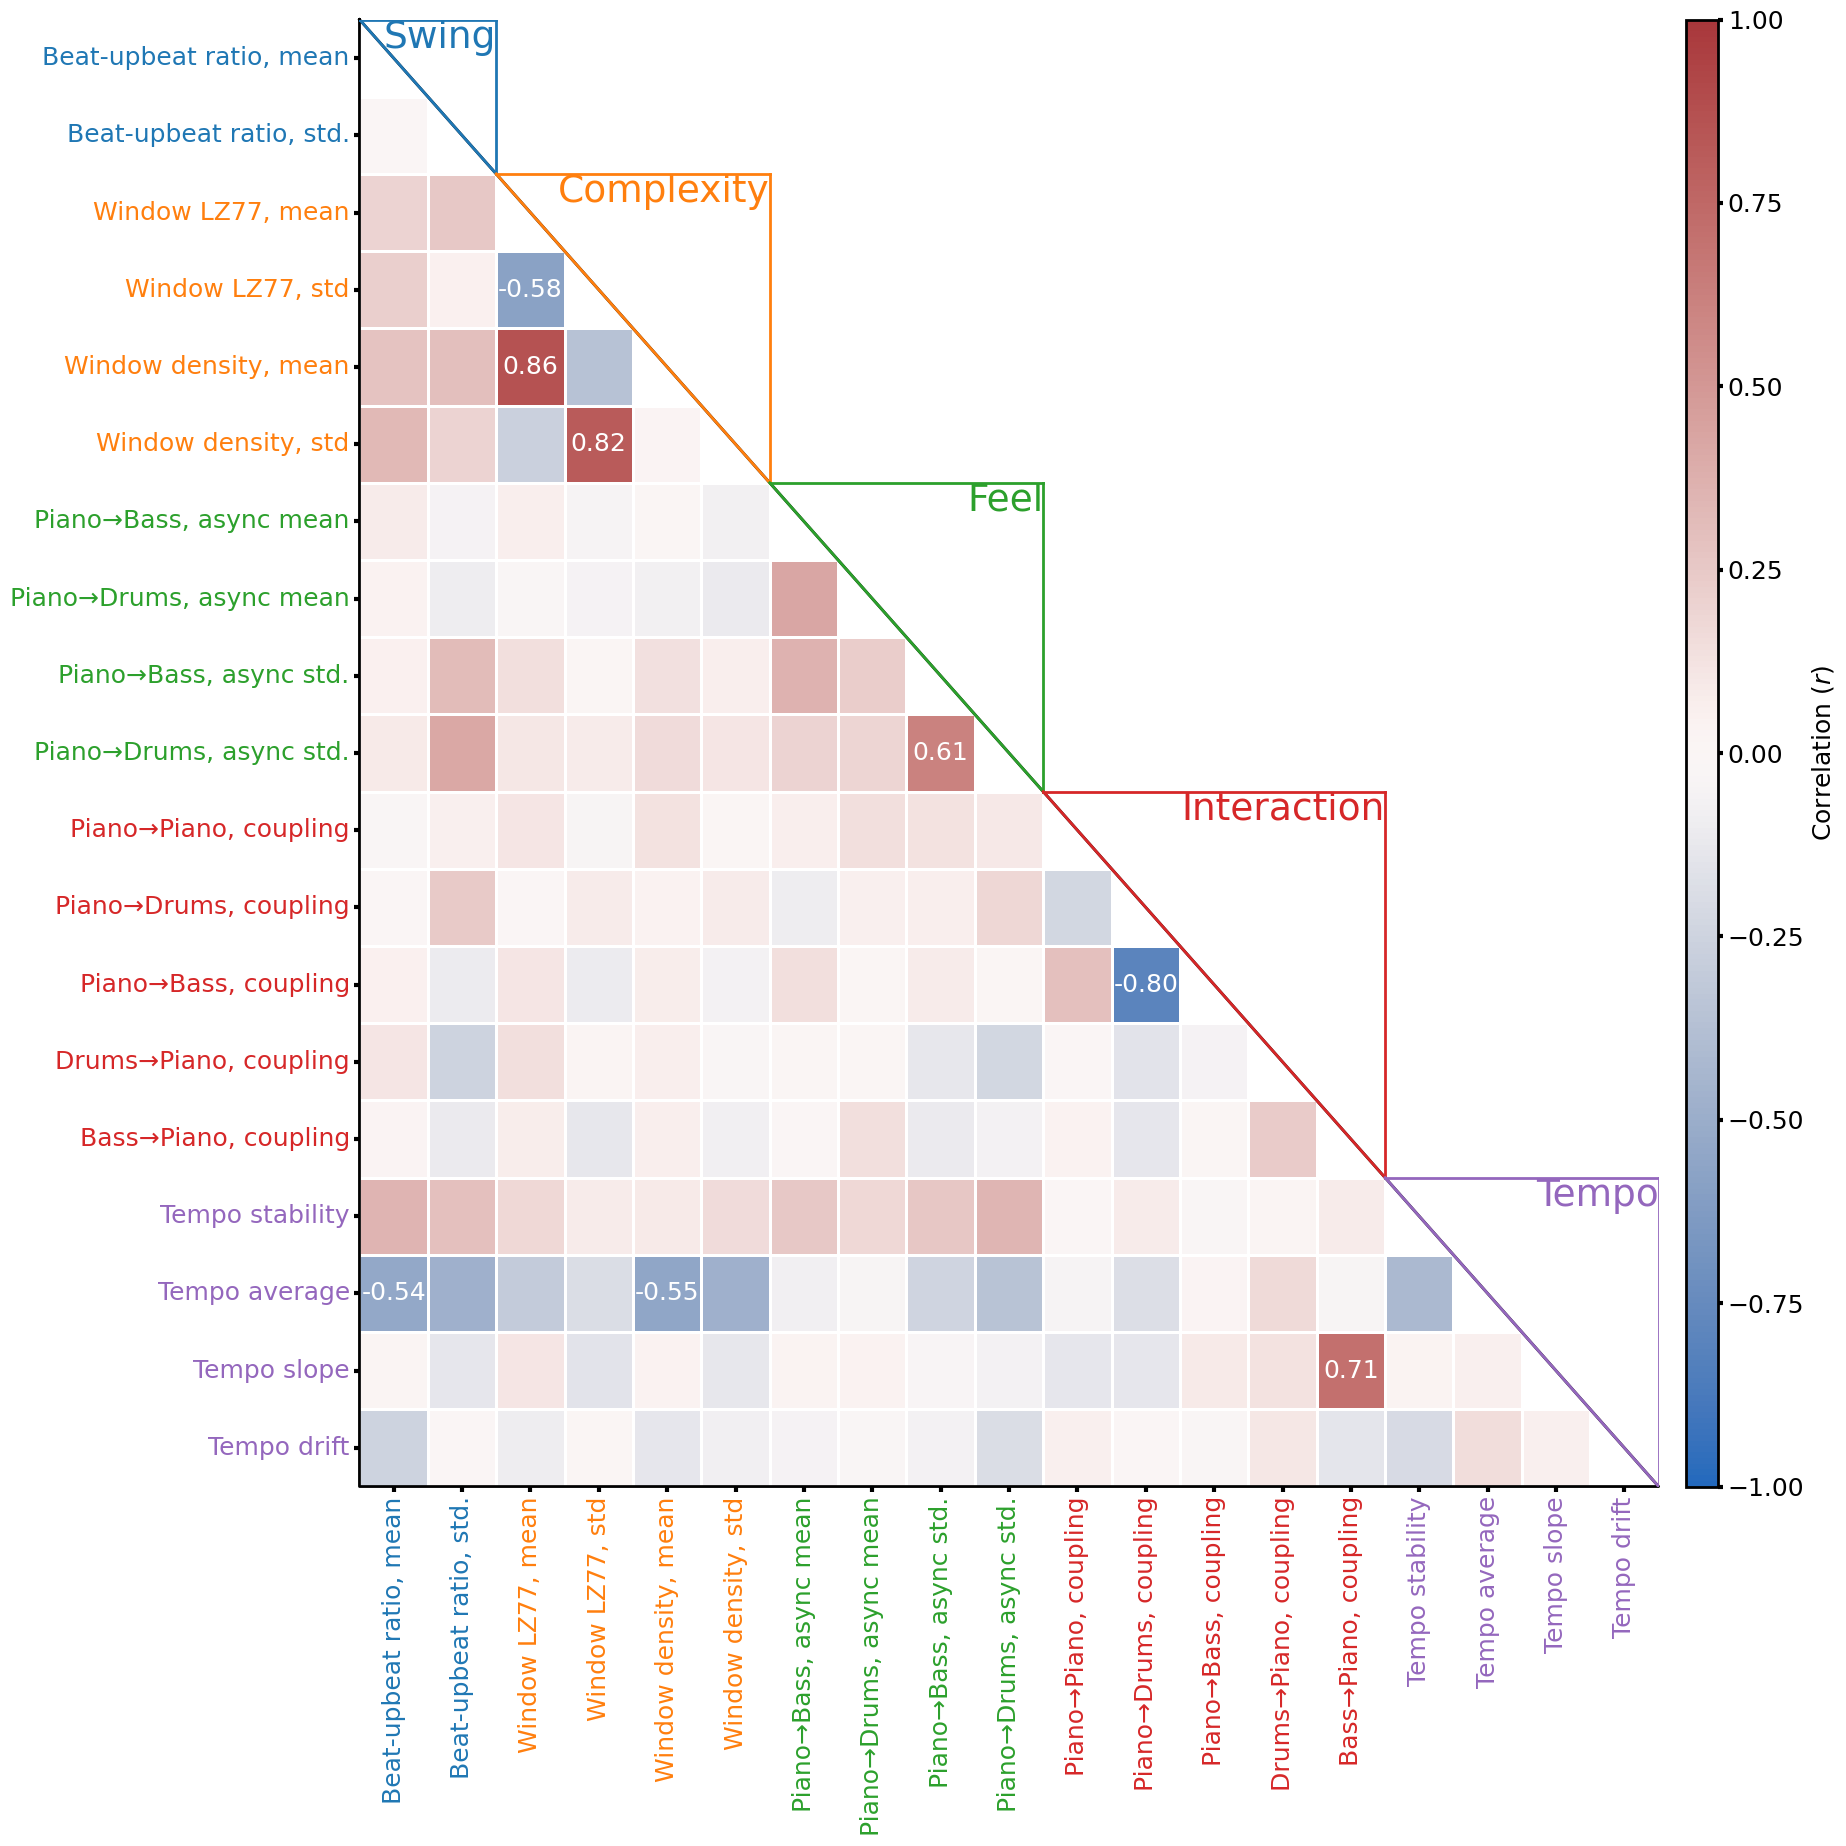

In [13]:
HeatMapFeatureCorrelation(df[PREDICTORS]).create_plot()
plt.show()

## Clean dataset
### Identify outliers
When cleaning the dataset, we first need to identify outlying values in our features. We set outlying values to `np.nan` so that we can set them to the overall average later, rather than removing the track completely. To start, we clean `self_coupling`, `coupling_bass`, or `coupling_drums` when `nobs < 30`: this means that we have fewer than 10 terms for each of our 3 predictors in the regression.

In [14]:
clean = df.copy(deep=True)

In [15]:
for col in ['self_coupling', 'coupling_bass', 'coupling_drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs'] = clean[f'nobs'].fillna(0)
    clean.loc[clean['nobs'] < 30, col] = np.nan

For the same reason, we clean `coupling_bass_piano` (i.e. bass coupling to piano) when `nobs_bass < 30` (sim. for `coupling_drums_piano` and `nobs_drums`)

In [16]:
for col in ['bass', 'drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs_{col}'] = clean[f'nobs_{col}'].fillna(0)
    clean.loc[clean[f'nobs_{col}'] < 30, f'coupling_piano_{col}'] = np.nan

We clean `bur_log_mean` and `bur_log)std` when `-2 <= average_bur <= 2` (these are the values discussed by Corcoran and Frieler) OR `bur_log_count_nonzero < 15` (we have fewer than 15 BURs in the track).

In [17]:
for col in ['bur_log_mean', 'bur_log_std']:
    clean.loc[clean['bur_log_mean'] < -2, col] = np.nan
    clean.loc[clean['bur_log_mean'] > 2, col] = np.nan
    clean.loc[clean['bur_log_count_nonzero'] < 15, col] = np.nan

We clean `bass/drums_prop_async` when `piano_prop_async_count_nonzero < 10`, i.e. we have fewer than 10 beat asynchronies

In [18]:
for col in ['bass', 'drums']:
    clean.loc[clean[f'piano_prop_async_count_nonzero'] < 10, f'piano_{col}_prop_async_nanmean'] = np.nan
    clean.loc[clean[f'piano_prop_async_count_nonzero'] < 10, f'piano_{col}_prop_async_nanstd'] = np.nan

We clean `tempo_slope` and `tempo_drift` when `tempo_slope.abs() < 0.15`, i.e. we accelerated (or decelerated) by more than 0.15 beats-per-minute-per-second. This is the upper limit of values suggested to be realistic for jazz ensembles in the control condition of our previous experiment.

In [19]:
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_slope'] = np.nan
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_drift'] = np.nan

We clean `rolling_std_median` when `rolling_std_median > 0.4`, i.e. the median standard deviation for a four-second window of 1/4 note beats is greater than 40 milliseconds. This is the upper limit of values for this variable from our earlier experiment.

In [20]:
clean.loc[clean['rolling_std_median'] > 0.4, 'rolling_std_median'] = np.nan

## Get number of missing values per predictor
Let's see how many missing values we have per predictor variable

In [21]:
clean[PREDICTORS].isna().sum()

bur_log_mean                       15
bur_log_std                        15
lz77_mean                           2
lz77_std                            2
n_onsets_mean                       2
n_onsets_std                        2
piano_bass_prop_async_nanmean      12
piano_drums_prop_async_nanmean      3
piano_bass_prop_async_nanstd       12
piano_drums_prop_async_nanstd       3
self_coupling                     128
coupling_drums                    128
coupling_bass                     128
coupling_piano_drums               71
coupling_piano_bass                95
rolling_std_median                  8
tempo                               0
tempo_slope                        24
tempo_drift                         0
dtype: int64

### Impute missing values based on feature average
We can now set missing values to the average for that feature across the entire dataset.

In [22]:
X = clean[PREDICTORS].fillna(clean[PREDICTORS].mean())

Let's check that we've filled all missing values

In [23]:
print(X.isna().values.any())

False


### Encode categorical prediction variable
Next, we need to encode our predictor variable (currently a list of names) to integers.

In [24]:
# We can store the labels for later use
pianist_labels = clean[PREDICTION].unique().tolist()
y = clean[PREDICTION].map({val: i for i, val in enumerate(pianist_labels)})

## Random Forest modelling (new)
### Create the model class

In [25]:
class RandomForestFit:
    """Provides a wrapper around `StratifiedKFold` and `RandomForestClassifier`"""
    def __init__(self, params: dict = None):
        self.params = params if params is not None else {}
        # I think we can probably shuffle the data first.
        # The data is unordered (not time-series), so unlikely to have a negative effect
        self.skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
        self.predicts, self.importances = [], []
        self.trees = []

    def fit_model(self, x_data, y_data):
        fits = [self._fit_model(x_data, y_data, x_idx, y_idx) for x_idx, y_idx in self.skf.split(x_data, y_data)]
        predicts, importances = list(zip(*fits))
        self.predicts = self._format_predicts_df(predicts)
        self.importances = self._format_importances_df(importances)
        return self

    def get_global_accuracy(self) -> float:
        """Returns the percentage of correct predictions"""
        return self.predicts['correct'].value_counts(normalize=True)[True]

    @staticmethod
    def _format_importances_df(importances) -> pd.DataFrame:
        importances_df_ = (
            pd.concat(importances, axis=1)
            .reset_index(drop=False)
            .rename(columns={'index': 'feature'})
        )
        importances_df_['category'] = importances_df_['feature'].map(CATEGORY_MAPPING)
        return importances_df_

    @staticmethod
    def _format_predicts_df(predicts) -> pd.DataFrame:
        predict_df_ = (
            pd.concat(predicts, axis=0)
            .sort_index()
            .rename(columns={0: 'prediction', 'pianist': 'actual'})
        )
        predict_df_['correct'] = predict_df_['prediction'] == predict_df_['actual']
        for var in ['prediction', 'actual']:
            predict_df_[var] = predict_df_[var].map({i: val for i, val in enumerate(pianist_labels)})
        return predict_df_

    def _fit_model(self, x_data, y_data, train_idx, test_idx):
        # Get our splits for this fold
        X_train, X_test = x_data.iloc[train_idx], x_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        # Create the random forest model
        rf = RandomForestClassifier(random_state=SEED, **self.params)
        # Fit the random forest to the training data
        rf.fit(X_train, y_train)
        self.trees.append(rf)
        # Predict the test data
        y_predict = rf.predict(X_test)
        # Get prediction probabilities
        y_probs = rf.predict_proba(X_test)
        # Return the prediction and feature importance dataframes
        return (
            self._format_predict_df(y_predict, y_probs, y_test),
            pd.Series(rf.feature_importances_, index=X.columns)
        )

    @staticmethod
    def _format_predict_df(predict, predict_probs, actual):
        y_probs = pd.DataFrame(predict_probs)
        y_probs.columns = y_probs.columns.map({i: val for i, val in enumerate(pianist_labels)})
        y_probs.index = actual.index
        # Format the prediction series
        y_predict_s = pd.Series(predict)
        y_predict_s.index = actual.index
        # Concatenate the predicted and actual pianist
        return pd.concat([y_predict_s, actual, y_probs], axis=1)

### Get baseline accuracy
Here, we just guess a random pianist for each track

In [26]:
accuracy_random = accuracy_score(y, np.random.randint(y.min(), y.max(), len(y)))
print(f"Random guess accuracy: {accuracy_random}")

Random guess accuracy: 0.1


As you'd expect with 10 pianists and 30 tracks per pianist, we'll be correct approximately one in ten times if we just guess the pianist at random.

### Fit the initial model and get accuracy
Here we just use the default parameters for fitting the model

In [27]:
rf_init = RandomForestFit().fit_model(X, y)
print(f'Initial model accuracy: {rf_init.get_global_accuracy()}')

Initial model accuracy: 0.51


### Parameter optimization
Now, we can try and optimize the model using a randomized search over an array of parameters

In [28]:
# These are the parameters we'll sample from when optimizing
test_params = dict(
    # The number of trees to grow in the forest
    n_estimators=[i for i in range(100, 2000, 10)],
    # Max number of features considered for splitting a node
    max_features=[None, 'sqrt', 'log2'],
    # Max number of levels in each tree
    max_depth=[None, *[i for i in range(10, 110, 10)]],
    # Minimum number of samples required to split a node
    min_samples_split=[i for i in range(1, 11)],
    # Minimum number of samples required at each leaf node
    min_samples_leaf=[i for i in range(1, 11)],
    # Whether to sample data points with our without replacement
    bootstrap=[True, False],
)

In [65]:
# Create the `ParameterSampler` object for the required number of iterations
sampler = ParameterSampler(test_params, n_iter=N_ITER, random_state=SEED)

In [66]:
# Create the model wrappers with the given parameters (fast!)
rfs = [RandomForestFit(params=param) for param in sampler]
# Use lazy parallelization to fit the models to the data (slow!)
with Parallel(n_jobs=N_JOBS, verbose=11) as parallel:
    rfs_fitted = parallel(delayed(f.fit_model)(X, y) for f in rfs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

In [67]:
# Create a dataframe of parameters and accuracy scores
opt_df = pd.DataFrame([
    {'accuracy': md.get_global_accuracy(), 'n_iter': num, **param}
    for num, (md, param) in enumerate(zip(rfs_fitted, sampler), 1)
])
opt_df.head()

,accuracy,n_iter,n_estimators,max_features,max_depth,bootstrap
0,0.520000,1,50,log2,30.0,True
1,0.486667,2,950,log2,30.0,False
2,0.486667,3,550,log2,80.0,False
3,0.490000,4,750,sqrt,20.0,True
4,0.473333,5,150,None,60.0,True


In [187]:
# Get the parameter combination that yielded the best accuracy
best_params = opt_df[opt_df['accuracy'] == opt_df['accuracy'].max()][test_params.keys()].to_dict('records')[0]
best_params['max_depth'] = int(best_params['max_depth'])

`{'n_estimators': 50,
 'max_features': 'log2',
 'max_depth': 30,
 'bootstrap': True}`

### Fit the optimized model and get accuracy
Now, we use the best combination of parameters from our optimization process

In [28]:
rf_opt = RandomForestFit(params={'n_estimators': 50, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}).fit_model(X, y)
print(f'Optimized model accuracy: {rf_opt.get_global_accuracy()}')

Optimized model accuracy: 0.52


## Plot results
### Plot feature importance
Which rhythmic features are most important in defining the personal style of a particular pianist?

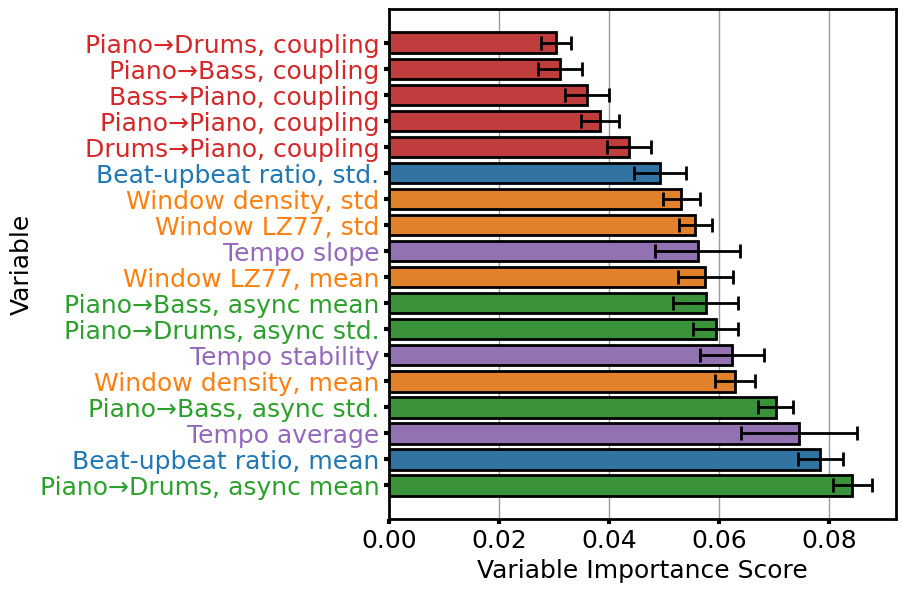

In [538]:
class BarPlotFeatureImportances(vutils.BasePlot):
    """Creates barplot showing importance of all features"""
    # These are the keywords we apply to all bar plots
    BAR_KWS = dict(
        dodge=False, edgecolor=vutils.BLACK, errorbar=None, lw=vutils.LINEWIDTH, capsize=0.1, width=0.8,
        ls=vutils.LINESTYLE, hue_order=PREDICTORS_CATEGORIES.keys(), zorder=3, estimator=np.mean,
    )
    ERROR_KWS = dict(ls='none', color=vutils.BLACK, elinewidth=2, capsize=5, markeredgewidth=2, zorder=5)
    # This creates a new dictionary with a unique hash for each predictor category
    hatches = {k: h for k, h in zip(PREDICTORS_CATEGORIES.keys(), vutils.HATCHES)}

    def __init__(self, importances: pd.DataFrame, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(figure_title=fr'random_forest_plots\barplot_feature_importances_{self.corpus_title}', **kwargs)
        # Create both dataframes
        self.importances = (
            importances.copy(deep=True)
            .melt(id_vars=['feature', 'category'], var_name='fold')
            .groupby('feature')
            [['value', 'category']]
            .agg({'value': [np.mean, np.std], 'category': 'first'})
            .droplevel(0, axis=1)
            .rename(columns={'first': 'category'})
            .reset_index(drop=False)
            .sort_values(by='mean')
        )
        self.importances['feature'] = self.importances['feature'].map(COL_MAPPING)
        # Create subplot matrix
        self.fig, self.ax = plt.subplots(
            nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 3)
        )

    def _create_plot(self) -> plt.Axes:
        """Creates all plots in seaborn with given arguments"""
        sns.barplot(
            data=self.importances, x='mean', y='feature', hue='category',
            ax=self.ax, **self.BAR_KWS
        )
        self.ax.errorbar(
            self.importances['mean'], self.importances['feature'],
            xerr=self.importances['std'], **self.ERROR_KWS
        )

    def _format_ticks(self):
        rev = {v: k for k, v in COL_MAPPING.items()}
        for tick in self.ax.get_yticklabels():
            var = rev[tick.get_text()]
            for cat, vars_ in PREDICTORS_CATEGORIES.items():
                if var in vars_:
                    tick.set_color(CATEGORY_CMAP[cat])

    def _format_ax(self) -> None:
        """Formats axis-level properties"""
        # Set variable labelling
        self.ax.set(ylabel='Variable', xlabel='Variable Importance Score')
        self._format_ticks()
        # Remove the legend
        self.ax.get_legend().remove()
        # Set the width of the edges and ticks
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
        self.ax.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)
        # Add a vertical grid
        self.ax.grid(zorder=0, axis='x', **vutils.GRID_KWS)

    def _format_fig(self) -> None:
        """Formats figure-level attributes"""
        self.fig.tight_layout()

BarPlotFeatureImportances(rf_opt.importances).create_plot()
plt.show()

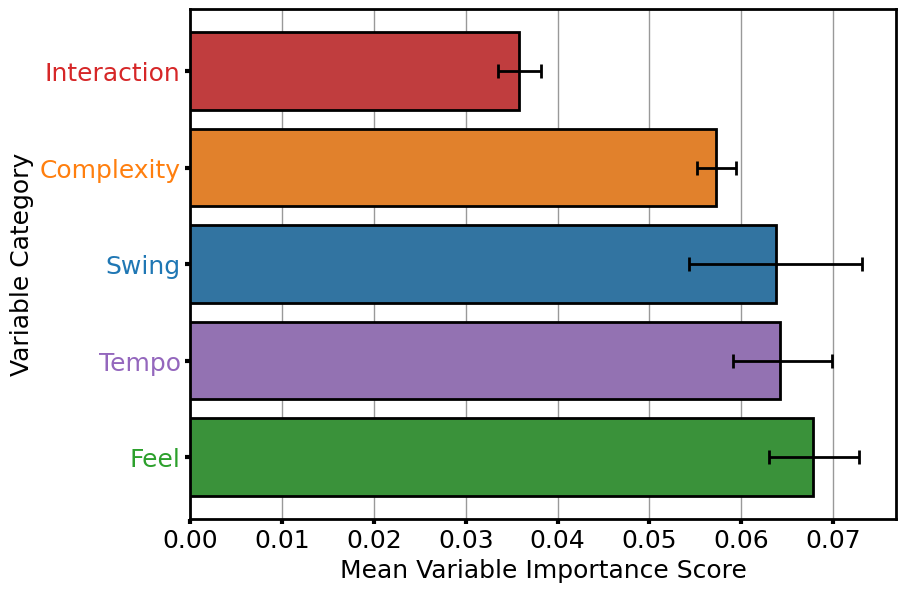

In [539]:
class BarPlotCategoryImportances(vutils.BasePlot):
    """Creates barplot showing average importance of feature category"""
    # These are the keywords we apply to all bar plots
    BAR_KWS = dict(
        dodge=False, edgecolor=vutils.BLACK, errorbar=None, lw=vutils.LINEWIDTH, capsize=0.1, width=0.8,
        ls=vutils.LINESTYLE, hue_order=PREDICTORS_CATEGORIES.keys(), zorder=3, estimator=np.mean,
    )
    ERROR_KWS = dict(ls='none', color=vutils.BLACK, elinewidth=2, capsize=5, markeredgewidth=2, zorder=5)
    # This creates a new dictionary with a unique hash for each predictor category
    hatches = {k: h for k, h in zip(PREDICTORS_CATEGORIES.keys(), vutils.HATCHES)}

    def __init__(self, importances: pd.DataFrame, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(figure_title=fr'random_forest_plots\barplot_category_importances_{self.corpus_title}', **kwargs)
        # Create both dataframes
        self.grouped_importances = (
            importances.copy(deep=True)
            .melt(id_vars=['feature', 'category'], var_name='fold')
            .groupby('category', as_index=False)
            ['value']
            .apply(self._bootstrap)
            .sort_values(by='mean')
        )
        # Create subplot matrix
        self.fig, self.ax = plt.subplots(
            nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 3)
        )

    @staticmethod
    def _bootstrap(vals, n_boot: int = vutils.N_BOOT):
        boots = [vals.sample(frac=1, replace=True, random_state=i).mean() for i in range(n_boot)]
        true_mean = np.mean(vals)
        return pd.Series({
            'low': true_mean - np.percentile(boots, 2.5),
            'mean': true_mean,
            'high': np.percentile(boots, 97.5) - true_mean
        })

    def _create_plot(self) -> plt.Axes:
        """Creates all plots in seaborn with given arguments"""
        sns.barplot(
            data=self.grouped_importances, x='mean', y='category',
            hue='category', ax=self.ax, **self.BAR_KWS
        )
        self.ax.errorbar(
            self.grouped_importances['mean'], self.grouped_importances['category'],
            xerr=(self.grouped_importances['low'], self.grouped_importances['high']),
            **self.ERROR_KWS
        )

    def _format_ticks(self):
        for tick in self.ax.get_yticklabels():
            tick.set_color(CATEGORY_CMAP[tick.get_text()])

    def _format_ax(self) -> None:
        """Formats axis-level properties"""
        # Set variable labelling
        self.ax.set(ylabel='Variable Category', xlabel='Mean Variable Importance Score')
        self._format_ticks()
        # Remove the legend
        self.ax.get_legend().remove()
        # Set the width of the edges and ticks
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
        self.ax.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)
        # Add a vertical grid
        self.ax.grid(zorder=0, axis='x', **vutils.GRID_KWS)

    def _format_fig(self) -> None:
        """Formats figure-level attributes"""
        self.fig.tight_layout()

BarPlotCategoryImportances(rf_opt.importances).create_plot()
plt.show()

### Plot prediction errors by pianist
Which pianist's style is easiest to predict based on rhythmic features alone?

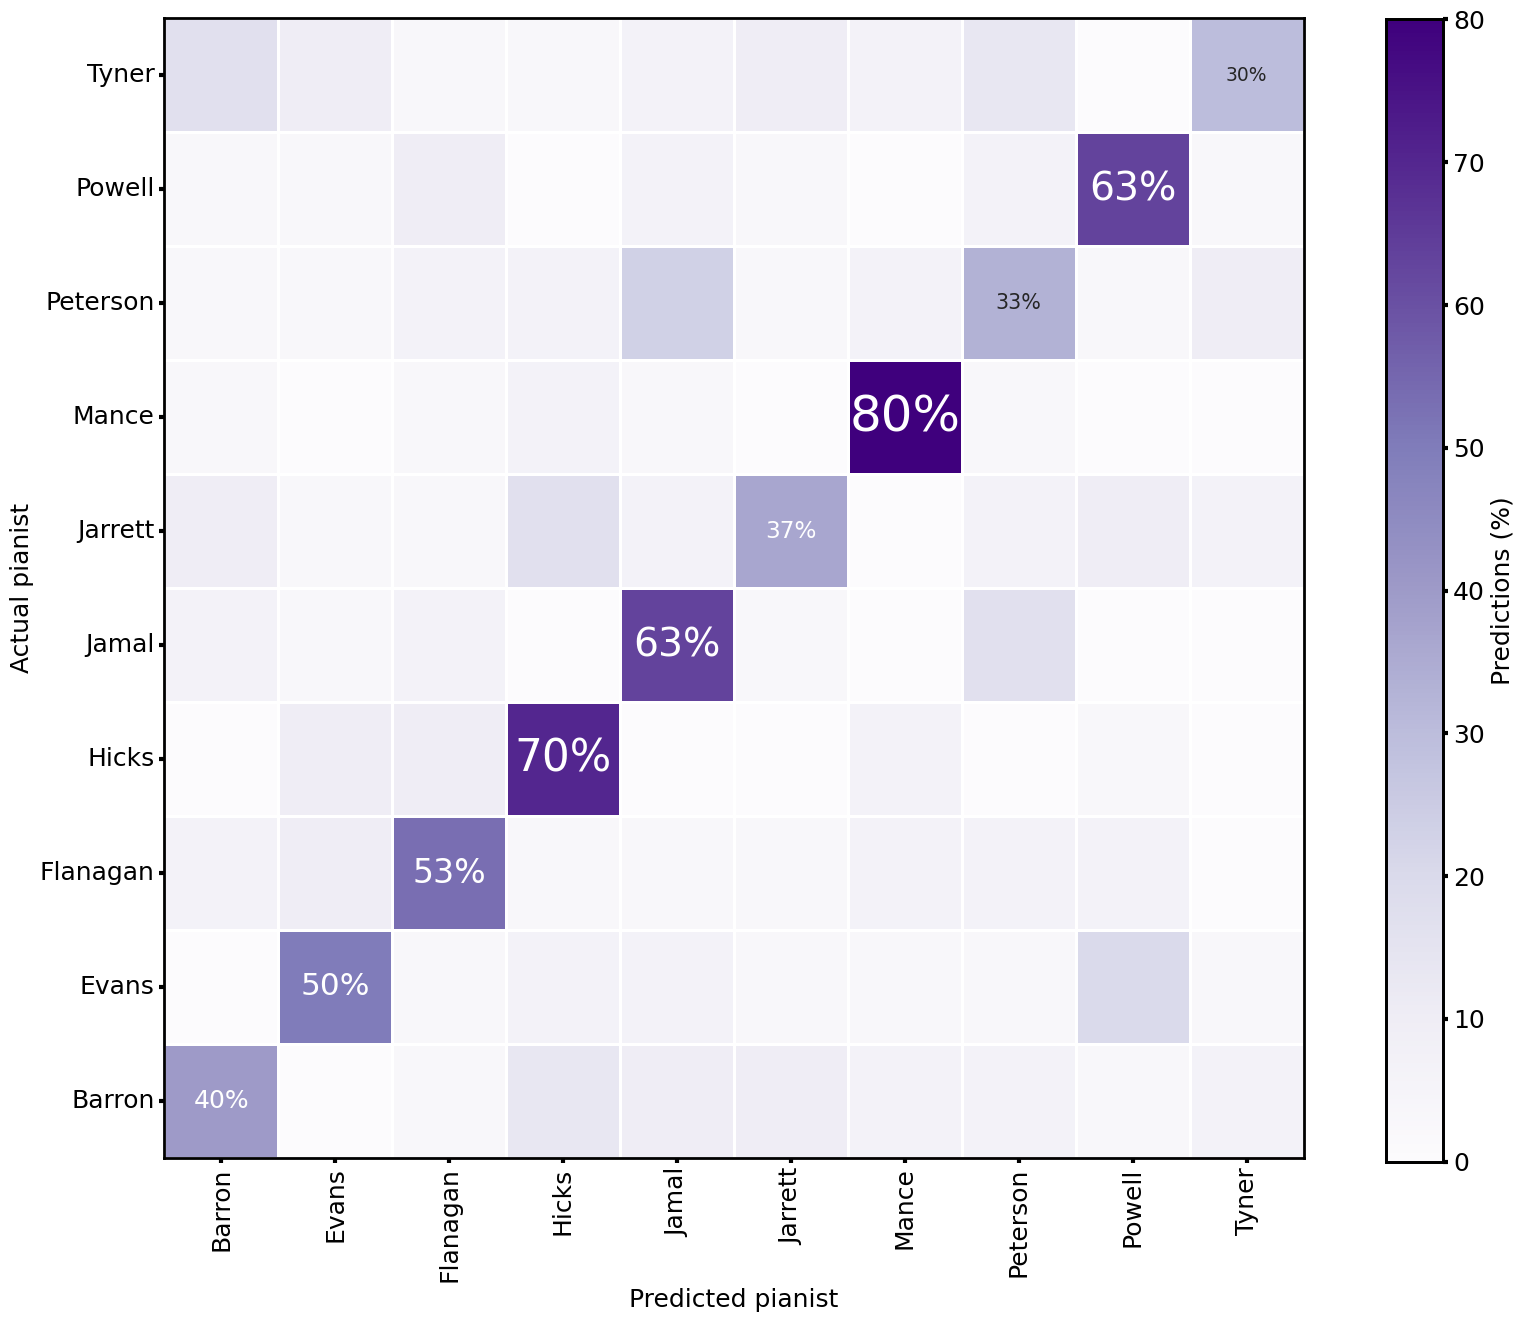

In [546]:
class HeatMapPredictionProb(vutils.BasePlot):
    def __init__(self, prob_df, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(figure_title=fr'random_forest_plots\heatmap_prediction_prob_{self.corpus_title}', **kwargs)
        self.hm = self._format_df(prob_df)
        self.fig = plt.figure(figsize=(vutils.WIDTH, vutils.WIDTH))
        gs0 = mpl.gridspec.GridSpec(1, 2, width_ratios=[20, 1], hspace=0.0, height_ratios=[1])
        self.ax = self.fig.add_subplot(gs0[0])

    @staticmethod
    def _format_df(prob_df):
        labs = [l.split(' ')[-1] for l in prob_df['actual'].unique()]
        hm = pd.DataFrame(confusion_matrix(prob_df['actual'], prob_df['prediction'], normalize='true'))
        hm *= 100
        hm.index = labs
        hm.columns = labs
        return hm.sort_index(ascending=False).reindex(sorted(hm.columns), axis=1)

    def _create_plot(self):
        sns.heatmap(
            self.hm, ax=self.ax, cmap="Purples", linecolor=vutils.WHITE, square=True,
            annot=True, fmt='.0f', linewidths=vutils.LINEWIDTH/2, vmin=self.hm.min().min(), vmax=self.hm.max().max(),
            cbar_kws=dict(
                label='Predictions (%)',
                use_gridspec=False, location="right", pad=0.2, shrink=0.725
            )
        )

    def _format_annotations(self):
        for t in self.ax.texts:
            if float(t.get_text()) > 25:
                t.set_fontsize((vutils.FONTSIZE * 2) * (int(t.get_text())) / 80)
                t.set_text(t.get_text() + '%')
            else:
                t.set_text('')

    def _format_ax(self):
        self._format_annotations()
        self.ax.set(ylabel='Actual pianist', xlabel='Predicted pianist')
        cax = self.ax.figure.axes[-1]
        for a in [self.ax, cax]:
            for spine in a.spines.values():
                spine.set_visible(True)
                spine.set_color(vutils.BLACK)
            plt.setp(a.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
            a.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)

    def _format_fig(self):
        self.fig.subplots_adjust(top=1, bottom=0.1, left=0.2, right=0.9)
        self.ax.figure.axes[-1].set_position([0.85, 0.245, 0.2, 0.6075])


HeatMapPredictionProb(rf_opt.predicts).create_plot()
plt.show()

### Visualise a single decision tree

[Text(0.37536764705882353, 0.9583333333333334, 'x[4] <= 18.288\ngini = 0.899\nsamples = 155\nvalue = [27, 24, 25, 26, 26, 22, 17, 25, 24, 24]'),
 Text(0.12058823529411765, 0.875, 'x[7] <= 0.021\ngini = 0.712\nsamples = 24\nvalue = [8, 4, 16, 0, 0, 0, 2, 0, 3, 2]'),
 Text(0.07647058823529412, 0.7916666666666666, 'x[16] <= 285.251\ngini = 0.776\nsamples = 16\nvalue = [8, 3, 3, 0, 0, 0, 2, 0, 3, 2]'),
 Text(0.047058823529411764, 0.7083333333333334, 'x[6] <= 0.011\ngini = 0.664\nsamples = 12\nvalue = [8, 3, 2, 0, 0, 0, 0, 0, 3, 0]'),
 Text(0.023529411764705882, 0.625, 'x[5] <= 9.224\ngini = 0.346\nsamples = 7\nvalue = [7, 0, 2, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.011764705882352941, 0.5416666666666666, 'gini = 0.0\nsamples = 6\nvalue = [7, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.03529411764705882, 0.5416666666666666, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 2, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.07058823529411765, 0.625, 'x[5] <= 7.107\ngini = 0.612\nsamples = 5\nvalue = [1, 3, 0, 0, 0, 0, 0, 0, 3, 

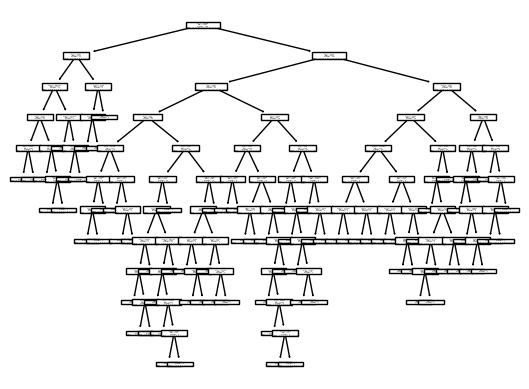

In [505]:
from sklearn import tree
tree.plot_tree(rf_opt.trees[0].estimators_[0])

In [534]:
norm = rf_opt.predicts.groupby('actual')[pianist_labels].mean()
for col in norm.columns:
    norm[col] /= norm[col].sum()
norm

,Ahmad Jamal,Bill Evans,Bud Powell,John Hicks,Junior Mance,Keith Jarrett,Kenny Barron,McCoy Tyner,Oscar Peterson,Tommy Flanagan
actual,,,,,,,,,,
Ahmad Jamal,0.288763,0.091573,0.096727,0.038287,0.049240,0.064262,0.068167,0.058259,0.147287,0.082051
Bill Evans,0.080979,0.238222,0.133091,0.079169,0.070239,0.072131,0.066843,0.098698,0.080103,0.083974
Bud Powell,0.102323,0.104180,0.354909,0.051914,0.018103,0.095082,0.062872,0.052090,0.093023,0.081410
John Hicks,0.041431,0.092900,0.047273,0.305646,0.062998,0.097705,0.096625,0.061001,0.067829,0.116667
Junior Mance,0.074074,0.055076,0.021091,0.061648,0.427227,0.057049,0.080079,0.093215,0.065245,0.089744
Keith Jarrett,0.062775,0.074320,0.080000,0.107722,0.049964,0.190820,0.108537,0.130226,0.098837,0.092949
Kenny Barron,0.067797,0.077638,0.067636,0.107722,0.080377,0.106230,0.238915,0.111720,0.064599,0.076282
McCoy Tyner,0.058380,0.103517,0.044364,0.069435,0.089790,0.123279,0.115817,0.206306,0.113695,0.076282
Oscar Peterson,0.144382,0.074320,0.088727,0.064893,0.076756,0.093115,0.067505,0.112406,0.182817,0.089103
